In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import scipy.sparse as sps
import scipy.io as sio
import os
import sys
import math
import gc
from os.path import join

sc.settings.verbosity = 0

In [2]:
sys.path.insert(0, '../..')
from src.ace import ACE
from src.preprocessing import lsiTransformer, ADTransformer, HARMONY

### loading data

In [3]:
root_dir = '../../data/Multiome'

dataset_path = os.path.join(
    root_dir, 
    'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_'
)

par = {
    'input_train_mod1': f'{dataset_path}train_mod1.h5ad',
    'input_train_mod2': f'{dataset_path}train_mod2.h5ad',
    'input_train_sol': f'{dataset_path}train_sol.h5ad',
    'input_test_sol': f'{dataset_path}test_sol.h5ad',
    'input_test_mod1': f'{dataset_path}test_mod1.h5ad',
    'input_test_mod2': f'{dataset_path}test_mod2.h5ad',
#     'output_pretrain': os.path.join(root_dir, 'output/pretrain/clue/openproblems_bmmc_multiome_phase2_rna.cl_train.output_pretrain/')
}

print('Reading `h5ad` files...')
input_train_mod1 = sc.read_h5ad(par['input_train_mod1'])
input_train_mod2 = sc.read_h5ad(par['input_train_mod2'])
input_train_sol = sc.read_h5ad(par['input_train_sol'])
input_test_mod1 = sc.read_h5ad(par['input_test_mod1'])
input_test_mod2 = sc.read_h5ad(par['input_test_mod2'])

print("Unscrambling training cells...")
ord = input_train_sol.X.tocsr().indices
if "pairing_ix" in input_train_sol.uns:
    assert np.all(ord == np.argsort(input_train_sol.uns["pairing_ix"]))
input_train_mod2 = input_train_mod2[ord, :].copy()
input_train_mod2.obs_names = input_train_mod1.obs_names

input_test_sol = sc.read_h5ad(par['input_test_sol'])
ord = input_test_sol.X.tocsr().indices
if "pairing_ix" in input_test_sol.uns:
    assert np.all(ord == np.argsort(input_test_sol.uns["pairing_ix"]))
input_test_mod2 = input_test_mod2[ord, :].copy()
input_test_mod2.obs_names = input_test_mod1.obs_names    

gex = input_train_mod1
other = input_train_mod2
gex_test = input_test_mod1
other_test = input_test_mod2

# rename to be consistent with meta data
def renames(df):
    df['full_names'] = df.index.to_numpy()
    df.index = [_.split('-')[0]+'-'+_.split('-')[1] for _ in df.index]
    return df

gex.obs = renames(gex.obs)
gex_test.obs = renames(gex_test.obs)
other.obs = renames(other.obs)
other_test.obs = renames(other_test.obs)

df_meta = pd.read_csv(os.path.join(root_dir, 'multiome_meta.csv'), index_col=0)
df_meta = renames(df_meta)
train_idx = ~df_meta.batch.isin(['s4d1', 's4d8', 's4d9'])
test_idx  = df_meta.batch.isin(['s4d1', 's4d8', 's4d9'])

gex.obs[['batch', 'cell_type']] = df_meta.loc[train_idx].loc[gex.obs_names, ['batch', 'cell_type']].copy()
gex_test.obs[['batch', 'cell_type']] = df_meta.loc[test_idx].loc[gex_test.obs_names, ['batch', 'cell_type']].copy()
other.obs[['batch', 'cell_type']] = df_meta.loc[train_idx].loc[other.obs_names, ['batch', 'cell_type']].copy()
other_test.obs[['batch', 'cell_type']] = df_meta.loc[test_idx].loc[other_test.obs_names, ['batch', 'cell_type']].copy()

Reading `h5ad` files...


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/size_factors' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/_index' was w

Unscrambling training cells...


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/uns' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/uns/dataset_id' w

### preprocessing

In [4]:
log_dir = '../../outputs/case2_Multiome'
os.makedirs(log_dir, exist_ok=True)

In [5]:
if not os.path.exists(join(log_dir, 'gex_train_input.npy')):
    ### rna preprocessing, quite a while :D
    gex_all = sc.concat([gex, gex_test])
    gene_transformer = lsiTransformer(192, drop_first=False, use_highly_variable=False, log=True, norm=True, 
        z_score=True, tfidf=True, svd=True, use_counts=True, pcaAlgo='randomized'
    )
    gex_all_dimred_df = gene_transformer.fit_transform(gex_all)
    gex_all_dimred = HARMONY(gex_all_dimred_df, gex_all.obs.batch.to_list(), use_gpu=True)
    gex.obsm['dimred_be'], gex_test.obsm['dimred_be'] = gex_all_dimred[:gex.shape[0]], gex_all_dimred[gex.shape[0]:]

    del gex_all, gex_all_dimred, gex_all_dimred_df
    gc.collect()

    ### ATAC preprocessing
    other_all = sc.concat([other, other_test])
    atac_transformer = lsiTransformer(256, drop_first=True, use_highly_variable=False, log=True, norm=True, 
        z_score=True, tfidf=True, svd=True, use_counts=True
    )
    other_all_df = atac_transformer.fit_transform(other_all)
    other_all_arr = HARMONY(other_all_df, other_all.obs.batch.to_list(), use_gpu=True)
    other.obsm['dimred_be'], other_test.obsm['dimred_be'] = other_all_arr[:other.shape[0]], other_all_arr[other.shape[0]:]

    del other_all, other_all_df, other_all_arr
    gc.collect()

    np.save(join(log_dir, 'gex_train_input.npy'), gex.obsm['dimred_be'])
    np.save(join(log_dir, 'gex_test_input.npy'),  gex_test.obsm['dimred_be'])
    np.save(join(log_dir, 'other_train_input.npy'), other.obsm['dimred_be'])
    np.save(join(log_dir, 'other_test_input.npy'), other_test.obsm['dimred_be'])
else:
    gex.obsm['dimred_be'] = np.load(join(log_dir, 'gex_train_input.npy'))
    gex_test.obsm['dimred_be'] = np.load(join(log_dir, 'gex_test_input.npy'))
    other.obsm['dimred_be'] = np.load(join(log_dir, 'other_train_input.npy'))
    other_test.obsm['dimred_be'] = np.load(join(log_dir, 'other_test_input.npy'))

In [7]:
n_parts = 3
modBatch_dict = {
    'rna': [gex, gex_test, None],
    'atac': [other, None, other_test]
}

useReps_dict = {
    'rna': 'dimred_be',
    'atac': 'dimred_be'
}

In [8]:
np.array(list(modBatch_dict.keys()))

array(['rna', 'atac'], dtype='<U4')

### stage1 training and inference

In [9]:
T = 0.1
model = ACE(
    modBatch_dict=modBatch_dict,  
    useReps_dict=useReps_dict,  
    batch_key='batch', 
    layers_dims = {'rna': [1024, 512], 'atac':[1024]}, 
    dropout_rates = {'rna': [0.34, 0.47], 'atac':[0.67]}, 
    T=math.log(1./T), T_learnable=True, log_dir=log_dir,
    n_latent1=40, n_latent2=256, seed=1234, num_workers=0
)

model.stage1_fit(
    batch_size=512,
    epochs=100,
    lr=2e-4, 
    log_step=10, 
)

batch0: ['rna', 'atac']
batch1: ['rna']
batch2: ['atac']
Batch ids used in training:  [0]
Training stage1
Epoch 9, loss=3.4654, temp=11.2509, batch0 loss=3.4654, 
Epoch 19, loss=3.2360, temp=12.9417, batch0 loss=3.2360, 
Epoch 29, loss=3.1207, temp=14.5220, batch0 loss=3.1207, 
Epoch 39, loss=3.0534, temp=15.9809, batch0 loss=3.0534, 
Epoch 49, loss=2.9855, temp=17.3292, batch0 loss=2.9855, 
Epoch 59, loss=2.9406, temp=18.5257, batch0 loss=2.9406, 
Epoch 69, loss=2.9063, temp=19.4743, batch0 loss=2.9063, 
Epoch 79, loss=2.8621, temp=20.2302, batch0 loss=2.8621, 
Epoch 89, loss=2.8320, temp=20.7377, batch0 loss=2.8320, 
Epoch 99, loss=2.8020, temp=21.0842, batch0 loss=2.8020, 


In [10]:
# stage1 inference
ad_integ = model.stage1_infer(
    modBatch_dict, useReps_dict, output_key='stage1_emb', 
    specify_mods_perBatch=[['rna'], ['rna'], ['atac']]
)
ad_integ

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 82510 × 40
    obs: 'batch', 'size_factors', 'full_names', 'cell_type', 'raw_batch', 'domain'

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


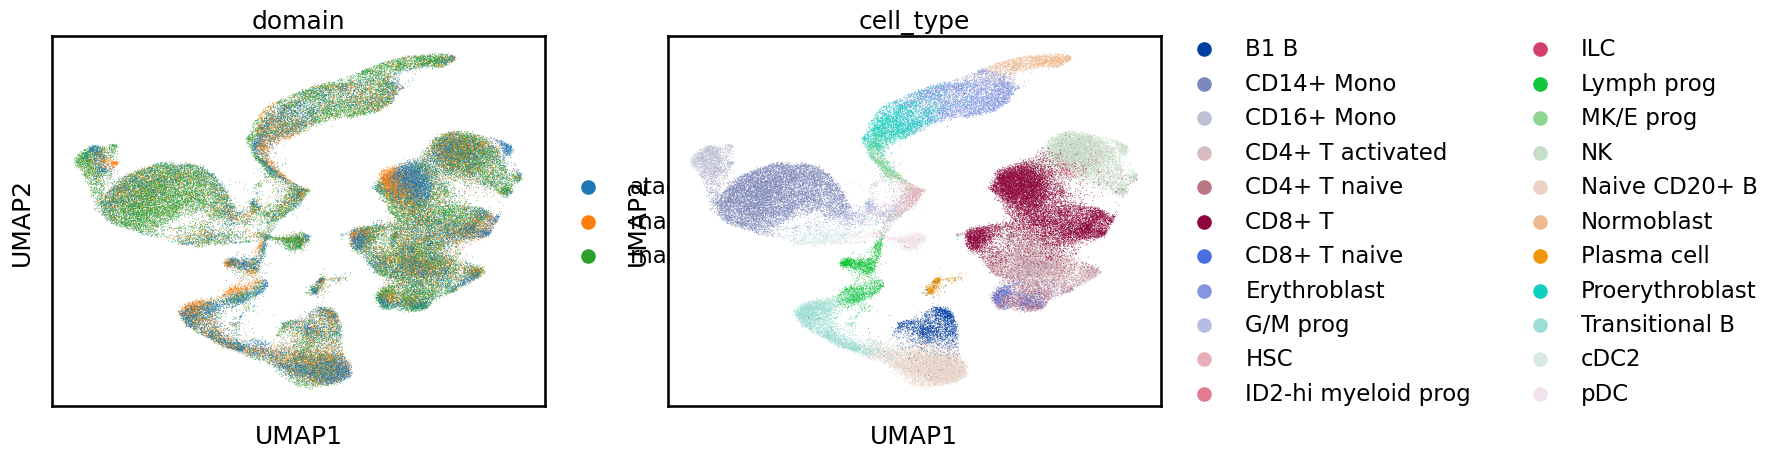

In [18]:
sc.pp.neighbors(ad_integ, n_neighbors=15, use_rep='X')
sc.tl.umap(ad_integ)

sc.pl.umap(ad_integ, color=['domain', 'cell_type'])

### stage2 training and inference

In [11]:
model.stage2_fit(
    batch_size=512,
    epochs=10,
    lr=1.75e-4, 
    log_step=5, 
    obvious_be=True,
)

Training stage2
Epoch 0, rna-loss=0.0375, atac-loss=0.0295, 
Epoch 4, rna-loss=0.0301, atac-loss=0.0280, 
Epoch 9, rna-loss=0.0292, atac-loss=0.0279, 


In [12]:
ad_integ2 = model.stage2_infer(
    modBatch_dict, useReps_dict, output_key1='stage1_emb', output_key2='stage2_emb', 
    knn=2, mod_weights={'rna':0.5, 'atac':0.5}
)

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


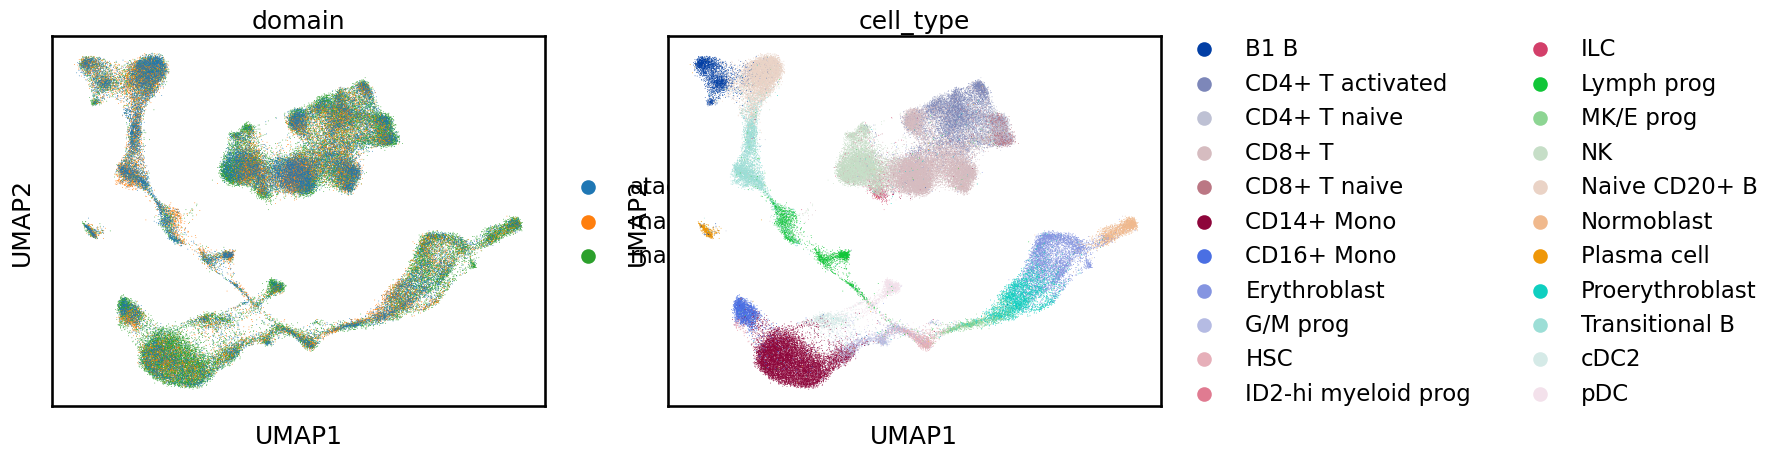

In [13]:
sc.pp.neighbors(ad_integ2, n_neighbors=15, use_rep='X')
sc.tl.umap(ad_integ2)

sc.pl.umap(ad_integ2, color=['domain', 'cell_type'])

## evaluation

In [14]:
from src.evaluation import eval_clustering, eval_lisi, eval_bridge, eval_bridge_above2

#### nmi, ari

In [15]:
ad_integ.obsm['stage1_emb'] = ad_integ.X.copy()
ad_integ2.obsm['final_emb'] = ad_integ2.X.copy()

nmi1, ari1 = eval_clustering(
    ad_integ, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='stage1_emb',
    use='nmi', nmi_method='arithmetic')

nmi2, ari2 = eval_clustering(
    ad_integ2, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='final_emb',
    use='nmi', nmi_method='arithmetic')

print('stage 1: nmi={:.4f}, ari={:.4f}'.format(nmi1, ari1))
print('stage 2: nmi={:.4f}, ari={:.4f}'.format(nmi2, ari2))

stage 1: nmi=0.7639, ari=0.6519
stage 2: nmi=0.7784, ari=0.7076


#### domain(modal)-lisi, batch-lisi

In [16]:
df_lisi1 = eval_lisi(
        ad_integ,
        batch_keys=['domain', 'batch'],
        use_rep='stage1_emb', use_neighbors=False,
    )

df_lisi2 = eval_lisi(
        ad_integ2,
        batch_keys=['domain', 'batch'],
        use_rep='final_emb', use_neighbors=False,
    )

print('stage 1: domain-lisi={:.4f}, batch-lisi={:.4f}'.format(df_lisi1.domain_LISI[0], df_lisi1.batch_LISI[0]))
print('stage 2: domain-lisi={:.4f}, batch-lisi={:.4f}'.format(df_lisi2.domain_LISI[0], df_lisi2.batch_LISI[0]))

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


stage 1: domain-lisi=0.5376, batch-lisi=0.2647
stage 2: domain-lisi=0.7355, batch-lisi=0.2807


#### modality alignment scores

In [17]:
bridge_dict = eval_bridge(
        modBatch_dict['rna'][1], modBatch_dict['atac'][2],
        label_key='cell_type',
        batch_key='batch',
        use_rep='stage1_emb',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.01775
Match_score=0.05302
